In [457]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3
import warnings
warnings.filterwarnings('ignore')

Call the Oxford data

In [468]:
dfGEO = pd.read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv",low_memory=False)
print(list(dfGEO))

df_pop = pd.read_csv(r"C:\Users\adamp\OneDrive\Desktop\Desktop\githubPage\Project 12\2019_Census_US_Population_Data_By_State_Lat_Long.csv")
print(list(df_pop))


['CountryName', 'CountryCode', 'RegionName', 'RegionCode', 'Jurisdiction', 'Date', 'C1_School closing', 'C1_Flag', 'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag', 'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport', 'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag', 'C7_Restrictions on internal movement', 'C7_Flag', 'C8_International travel controls', 'E1_Income support', 'E1_Flag', 'E2_Debt/contract relief', 'E3_Fiscal measures', 'E4_International support', 'H1_Public information campaigns', 'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing', 'H4_Emergency investment in healthcare', 'H5_Investment in vaccines', 'H6_Facial Coverings', 'H6_Flag', 'H7_Vaccination policy', 'H7_Flag', 'H8_Protection of elderly people', 'H8_Flag', 'M1_Wildcard', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex', 'StringencyIndexForDisplay', 'StringencyLegacyIndex', 'StringencyLegacyIndexForDisplay', 'GovernmentResponseIndex', 'GovernmentResponseIndexFor

Using mostly SQL to parse ou the US data.  Also the Oxford data contains cumulative case counts, this step lags each row for a count per day. It also replaces nulls with 0's

In [3]:
from pandasql import sqldf
# https://towardsdatascience.com/how-to-use-sql-in-pandas-62d8a0f6341
"""After you’ve imported everything, it’s a good idea to write a quick lambda function that can make writing your
queries easier. The reason for doing this is so that you don’t have to pass in global variables every time an object is used. 
Below is the lambda function that I was taught and have success with:"""
pysqldf = lambda q: sqldf(q, globals())

In [469]:
q = """SELECT DISTINCT
            RegionName as state,CAST(Date AS DATE) AS date
            ,substr(date,0,7)  as YYYYMM
            /* FROM CODEBOOK
            0 - No policy
            1 - Recommended
            2 - Required in some specified shared/public spaces outside the home with other people present, or some situations when social distancing not possible
            3 - Require
            d in all shared/public spaces outside the home with other people present or all situations when social distancing not possible
            4 - Required outside the home at all times regardless of location or presence of other people*/
            
            ,CASE WHEN "H6_Facial Coverings" IS NULL THEN 0 ELSE "H6_Facial Coverings" END AS face_covering_scale
            
            
            ,CASE WHEN ConfirmedCases IS NULL THEN 0 ELSE ConfirmedCases END AS CumConfirmedCases
            /*lag each row by one to get and subtract from the current record to get the daily case counts*/
            ,CASE WHEN ConfirmedCases IS NULL THEN 0 ELSE ConfirmedCases END 
                -lag(CASE WHEN ConfirmedCases IS NULL THEN 0 ELSE ConfirmedCases END , 1,0) OVER(partition by RegionName ORDER BY date asc) 
                    as dailyConfirmedCases
            ,RegionName||Date as ind
       FROM dfGEO a
       WHERE CountryName = 'United States' and RegionCode IS NOT NULL and Date < 20210801
;"""

df_orig = pysqldf(q)

In [470]:
df = df_orig.copy()
df.tail()

,state,date,YYYYMM,face_covering_scale,CumConfirmedCases,dailyConfirmedCases,ind
29473,Wyoming,20210727,202107,0.0,64623.0,172.0,Wyoming20210727
29474,Wyoming,20210728,202107,0.0,64623.0,0.0,Wyoming20210728
29475,Wyoming,20210729,202107,0.0,64955.0,332.0,Wyoming20210729
29476,Wyoming,20210730,202107,0.0,65127.0,172.0,Wyoming20210730
29477,Wyoming,20210731,202107,0.0,65127.0,0.0,Wyoming20210731


## Send this dataset to Tableau for some visualizations

In [471]:
q = """

        with a as (SELECT 
            df.state
            ,date
            ,POPESTIMATE2019
            ,dailyConfirmedCases
            ,face_covering_scale
            ,((dailyConfirmedCases)/POPESTIMATE2019)*100000 AS DailyCasesPop
            ,CASE WHEN face_covering_scale > 2 THEN 1 ELSE 0 END AS face_covering_required
        FROM df 
        inner join
            df_pop ON df_pop.STATE = df.state
        where date >20200416 and date<202010730)
    

select
    state,date,DailyCasesPop,POPESTIMATE2019,dailyConfirmedCases,face_covering_scale
    ,face_covering_required
    , CASE WHEN face_covering_required = 1 THEN 'Masked' ELSE 'Not Masked' END AS face_covering_required_desc

    ,avg(DailyCasesPop) OVER (PARTITION BY state ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS DailyCasesPop7Day
from a

;"""

df_tableau = pysqldf(q)
df_tableau.to_csv(r'C:\Users\adamp\OneDrive\Desktop\Desktop\githubPage\Project 12\df_tableau.csv', index=False)

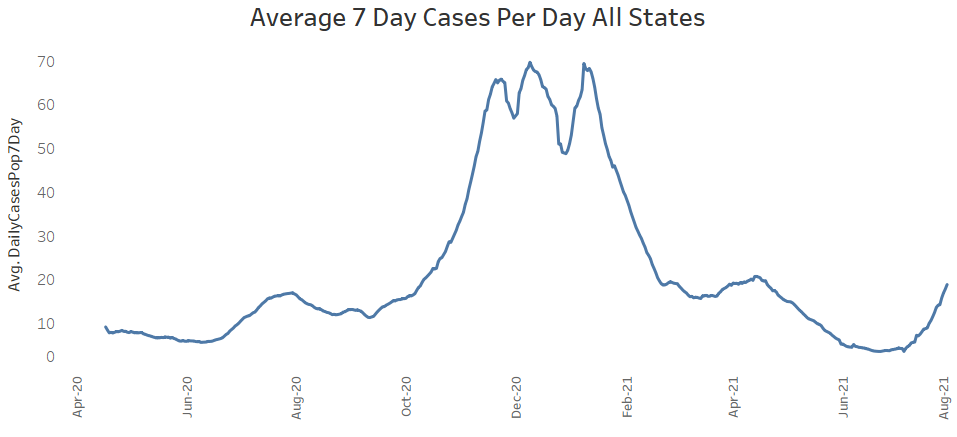

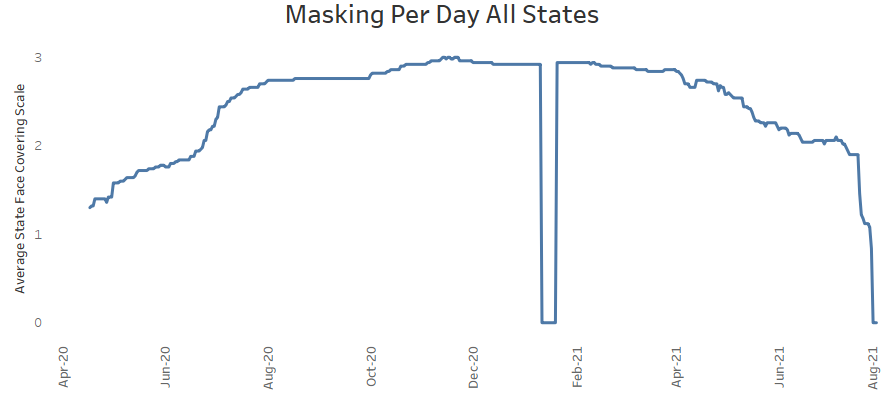

Odd that there is a huge gap in January 2020 for all states. I will need to address this before proceeding. This step imputes the data with the mode value. 

First step, get the surrounding months

In [472]:
q = """ 
    select state,date,face_covering_scale
    FROM df_orig 
    WHERE date between '20201231' and '20210201'

;"""

df_january = pysqldf(q)
df_january.tail(50)

,state,date,face_covering_scale
1633,Wisconsin,20210116,0.0
1634,Wisconsin,20210117,0.0
1635,Wisconsin,20210118,0.0
1636,Wisconsin,20210119,0.0
1637,Wisconsin,20210120,3.0
1638,Wisconsin,20210121,3.0
1639,Wisconsin,20210122,3.0
1640,Wisconsin,20210123,3.0
1641,Wisconsin,20210124,3.0
1642,Wisconsin,20210125,3.0


In [473]:
imputedVals=df_january.groupby(['state'])['face_covering_scale'].agg(pd.Series.mode).to_frame()
imputedVals

,face_covering_scale
state,
Alabama,3.0
Alaska,3.0
Arizona,3.0
Arkansas,3.0
California,3.0
Colorado,3.0
Connecticut,3.0
Delaware,4.0
Florida,3.0


In [474]:
q = """
SELECT
a.state,a.date,a.YYYYMM
,a.face_covering_scale as face_covering_scale_orig
,CASE WHEN a.date between '20200112' and '20210228' AND  a.face_covering_scale = 0 
    THEN b.face_covering_scale 
        ELSE a.face_covering_scale 
            END AS face_covering_scale
,CumConfirmedCases     
,dailyConfirmedCases
FROM (
SELECT DISTINCT
            RegionName as state
            ,CAST(Date AS DATE) AS date
            ,substr(date,0,7)  as YYYYMM
            /* FROM CODEBOOK
            0 - No policy
            1 - Recommended
            2 - Required in some specified shared/public spaces outside the home with other people present, or some situations when social distancing not possible
            3 - Required in all shared/public spaces outside the home with other people present or all situations when social distancing not possible
            4 - Required outside the home at all times regardless of location or presence of other people*/
            
            ,CASE WHEN "H6_Facial Coverings" IS NULL THEN 0 ELSE "H6_Facial Coverings" END AS face_covering_scale
            
            
            ,CASE WHEN ConfirmedCases IS NULL THEN 0 ELSE ConfirmedCases END AS CumConfirmedCases
            /*lag each row by one to get and subtract from the current record to get the daily case counts*/
            ,CASE WHEN ConfirmedCases IS NULL THEN 0 ELSE ConfirmedCases END 
                -lag(CASE WHEN ConfirmedCases IS NULL THEN 0 ELSE ConfirmedCases END , 1,0) OVER(partition by RegionName ORDER BY date asc) 
                    as dailyConfirmedCases
            ,RegionName||Date as ind
       FROM dfGEO a
  
       WHERE CountryName = 'United States' and RegionCode IS NOT NULL and Date < 20210730
       )a
             LEFT JOIN
            imputedVals b ON a.state = b.state

;"""

df_orig2 = pysqldf(q)

In [475]:
df = df_orig2.copy()
df.tail()

,state,date,YYYYMM,face_covering_scale_orig,face_covering_scale,CumConfirmedCases,dailyConfirmedCases
29371,Wyoming,20210725,202107,0.0,0.0,64251.0,0.0
29372,Wyoming,20210726,202107,0.0,0.0,64451.0,200.0
29373,Wyoming,20210727,202107,0.0,0.0,64623.0,172.0
29374,Wyoming,20210728,202107,0.0,0.0,64623.0,0.0
29375,Wyoming,20210729,202107,0.0,0.0,64955.0,332.0


In [477]:
q = """
        with a as (SELECT 
            df.state
            ,date
            ,POPESTIMATE2019
            ,dailyConfirmedCases
            ,face_covering_scale
            ,((dailyConfirmedCases)/POPESTIMATE2019)*100000 AS DailyCasesPop
            ,CASE WHEN face_covering_scale > 2 THEN 1 ELSE 0 END AS face_covering_required
        FROM df 
        inner join
            df_pop ON df_pop.STATE = df.state
        where date >20200401 and date<202010801)
    

select
    state,date,DailyCasesPop,POPESTIMATE2019,dailyConfirmedCases,face_covering_scale
    ,face_covering_required
    , CASE WHEN face_covering_required = 1 THEN 'Masked' ELSE 'Not Masked' END AS face_covering_required_desc

    ,avg(DailyCasesPop) OVER (PARTITION BY state ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS DailyCasesPop7Day
from a

;"""

df_tableau = pysqldf(q)
df_tableau.to_csv(r'C:\Users\adamp\OneDrive\Desktop\Desktop\githubPage\Project 12\df_tableau.csv', index=False)

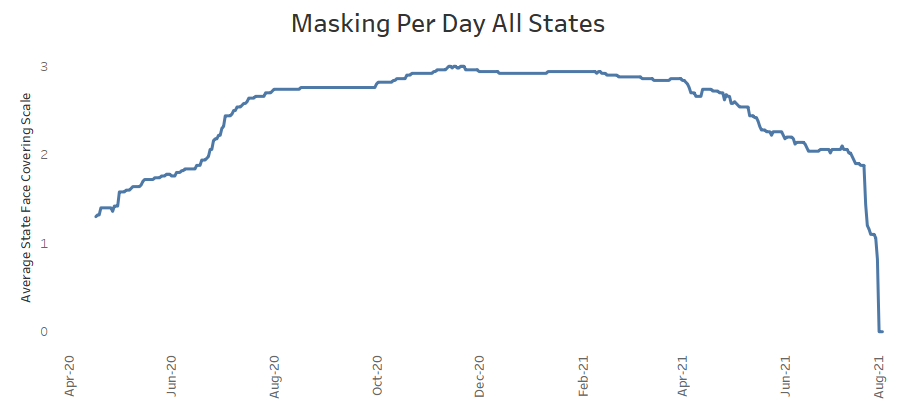

MUCH BETTER! 

The map below can be viewed in tableau as a timelapse. However, I question some of the data. Notice Texas had a mask mandate after California. Texas ended their mandate in March.Either way, this is the go forward dataset.

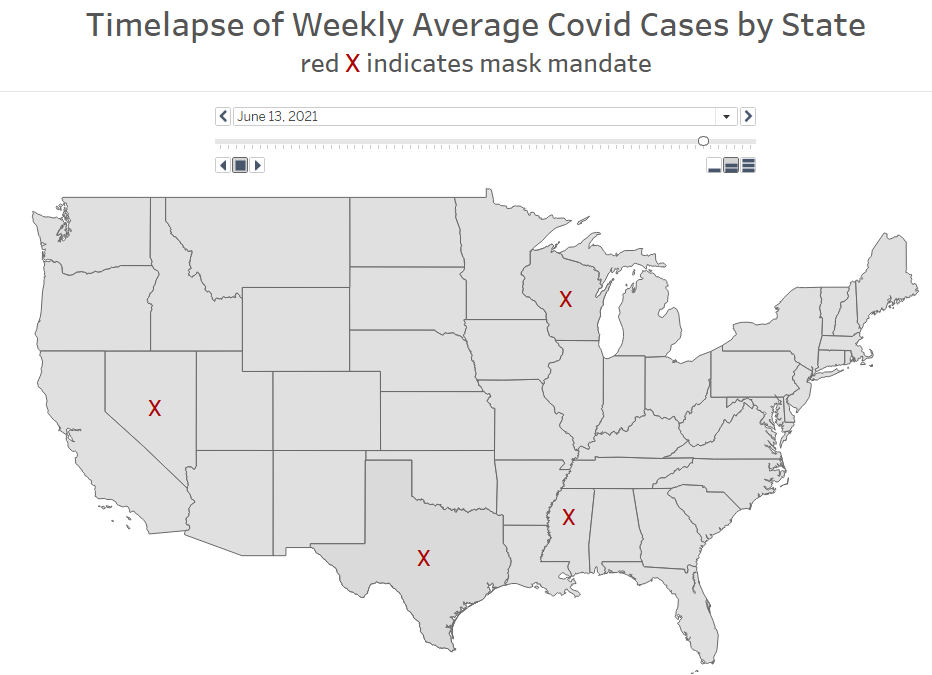

## This step aggregates at the state level. It categorizes the various facial covering stringencies. 


In [536]:
q = """SELECT DISTINCT
            state
            --,YYYYMM
            ,COUNT(DISTINCT CASE WHEN face_covering_scale > 2 THEN YYYYMM ELSE NULL END) AS MonthsWMask
            ,MIN(DISTINCT CASE WHEN face_covering_scale > 2 THEN YYYYMM ELSE NULL END) AS MinMonthsWMask
            ,MAX(DISTINCT CASE WHEN face_covering_scale > 2 THEN YYYYMM ELSE NULL END) AS MaxMonthsWMask
            ,SUM(dailyConfirmedCases) AS TotalCases
            ,SUM(face_covering_scale) as Sumface_covering_scale
            ,SUM(CASE WHEN face_covering_scale = 1 THEN 1 ELSE 0 END) AS Recommended
            ,SUM(CASE WHEN face_covering_scale = 2 THEN 1 ELSE 0 END) AS RequiredInSome
            ,SUM(CASE WHEN face_covering_scale = 3 THEN 1 ELSE 0 END) AS RequiredInAll
            ,SUM(CASE WHEN face_covering_scale = 4 THEN 1 ELSE 0 END) AS RequiredOutside
        FROM df
        where face_covering_scale > 0 
        group by 1--,2
        order by 2 desc
       
;"""

df_mask_required = pysqldf(q)
df_mask_required


,state,MonthsWMask,MinMonthsWMask,MaxMonthsWMask,TotalCases,Sumface_covering_scale,Recommended,RequiredInSome,RequiredInAll,RequiredOutside
0,New York,19,202001,202107,2138643.0,1611.0,16,43,503,0
1,Alaska,18,202001,202107,73374.0,1499.0,86,0,471,0
2,California,18,202001,202106,3865655.0,1615.0,3,44,508,0
3,Mississippi,18,202001,202107,335437.0,1543.0,61,0,494,0
4,Nevada,18,202001,202107,351443.0,1557.0,36,57,469,0
5,New Mexico,18,202001,202106,205701.0,1522.0,31,39,471,0
6,Connecticut,17,202001,202105,352626.0,1585.0,16,69,477,0
7,Delaware,17,202001,202105,110862.0,1714.0,24,67,328,143
8,Florida,17,202001,202105,2517573.0,1574.0,12,79,468,0
9,Hawaii,17,202001,202107,39386.0,1560.0,14,77,464,0


In [479]:
print('list the unique categorical variables for counts')
print(df_mask_required.describe(include=['O']))

list the unique categorical variables for counts
           state MinMonthsWMask MaxMonthsWMask
count         51             46             46
unique        51              3              6
top     Kentucky         202001         202105
freq           1             44             18


In [480]:
print(df_mask_required.Sumface_covering_scale.describe())

count      51.000000
mean     1426.176471
std       198.936945
min       989.000000
25%      1336.500000
50%      1453.000000
75%      1548.500000
max      1887.000000
Name: Sumface_covering_scale, dtype: float64


This step looks for which states were the most stringent and least stringent with mask policy. Using "Sumface_covering_scale" as the gauge.

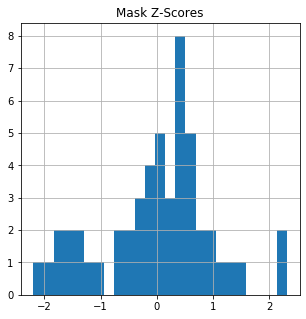

In [519]:
f, ax = plt.subplots(figsize=(5, 5))
df_mask_required['zscore_mask'] = (df_mask_required.Sumface_covering_scale - 
                                  df_mask_required.Sumface_covering_scale.mean())/df_mask_required.Sumface_covering_scale.std()

df_mask_required['zscore_mask'].hist(bins=25).set_title('Mask Z-Scores')

df_mask_required['low_mask'] = (df_mask_required['zscore_mask'] <=-1.8).astype(int)
df_mask_required['high_mask'] = (df_mask_required['zscore_mask'] >=1.8).astype(int)

In [482]:
q = """SELECT DISTINCT state ,'Low Masks',zscore_mask FROM df_mask_required where low_mask = 1
        UNION 
       SELECT DISTINCT state ,'High Masks',zscore_mask FROM df_mask_required where high_mask = 1
       
;"""

pysqldf(q)

,state,'Low Masks',zscore_mask
0,Georgia,Low Masks,-2.197563
1,Massachusetts,High Masks,2.316430
2,Minnesota,Low Masks,-1.825586
3,Nebraska,Low Masks,-1.981414
4,North Carolina,High Masks,2.306377


In [520]:
q = """SELECT 
            df.state
            ,YYYYMM
            ,POPESTIMATE2019
            ,CASE WHEN df.state IN (select distinct state from df_mask_required where high_mask = 1) THEN 1 ELSE 0 END AS HighMasking
            ,ROUND(AVG(CASE WHEN face_covering_scale > 2 THEN 1 ELSE 0 END)) AS MaskMonth
            ,SUM(dailyConfirmedCases) AS TotalCases
            ,(SUM(dailyConfirmedCases)/POPESTIMATE2019)*100000 AS TotalCasesPop
            ,SUM(face_covering_scale) as Sumface_covering_scale
            ,SUM(CASE WHEN face_covering_scale = 1 THEN 1 ELSE 0 END) AS Recommended
            ,SUM(CASE WHEN face_covering_scale = 2 THEN 1 ELSE 0 END) AS RequiredInSome
            ,SUM(CASE WHEN face_covering_scale = 3 THEN 1 ELSE 0 END) AS RequiredInAll
            ,SUM(CASE WHEN face_covering_scale = 4 THEN 1 ELSE 0 END) AS RequiredOutside
        FROM df 
        inner join
            df_pop ON df_pop.STATE = df.state
        WHERE
            df.state in (select distinct state from df_mask_required where high_mask = 1 OR low_mask=1)
        GROUP BY 1,2,3,4
;"""

df_mask_required = pysqldf(q)
df_mask_required.tail()

,state,YYYYMM,POPESTIMATE2019,HighMasking,MaskMonth,TotalCases,TotalCasesPop,Sumface_covering_scale,Recommended,RequiredInSome,RequiredInAll,RequiredOutside
90,North Carolina,202103,10488084,1,1.0,55584.0,529.972872,93.0,0,0,31,0
91,North Carolina,202104,10488084,1,1.0,55620.0,530.316119,89.0,0,1,29,0
92,North Carolina,202105,10488084,1,0.0,31402.0,299.406450,62.0,0,31,0,0
93,North Carolina,202106,10488084,1,0.0,12535.0,119.516587,60.0,0,30,0,0
94,North Carolina,202107,10488084,1,0.0,31188.0,297.366039,52.0,0,26,0,0


## What states have the most stringent and least stringent masking policies?
            --HIGH--
	North Carolina (>2 Stdevs)
    Massachusetts (highest >2 Stdevs)
    
            --LOW--
    Georgia (lowest >2 Stdevs)
	Minnesota (~2 Stdevs)
	Nebraska (~2 Stdevs)

## This next step will explore the correlation between cases and masking
### Hypothesis - Masking will reduce covid cases at the state level. 
This first step will aggregate those states that stood out in the prior step as they are on the extremes of the policies implemented.

In [505]:
q = """SELECT 
            df.state
            ,YYYYMM
            ,POPESTIMATE2019
            ,CASE WHEN df.state IN (select distinct state from df_mask_required where high_mask = 1) THEN 1 ELSE 0 END AS HighMasking
            ,SUM(dailyConfirmedCases) AS TotalCases
            ,ROUND(AVG(CASE WHEN face_covering_scale > 2 THEN 1 ELSE 0 END)) AS MaskMonth
            ,(SUM(dailyConfirmedCases)/POPESTIMATE2019)*100000 AS TotalCasesPop
            ,SUM(face_covering_scale) as Sumface_covering_scale
            ,SUM(CASE WHEN face_covering_scale = 1 THEN 1 ELSE 0 END) AS Recommended
            ,SUM(CASE WHEN face_covering_scale = 2 THEN 1 ELSE 0 END) AS RequiredInSome
            ,SUM(CASE WHEN face_covering_scale = 3 THEN 1 ELSE 0 END) AS RequiredInAll
            ,SUM(CASE WHEN face_covering_scale = 4 THEN 1 ELSE 0 END) AS RequiredOutside
        FROM df 
        inner join
            df_pop ON df_pop.STATE = df.state
        WHERE
            df.state in (select distinct state from df_mask_required where low_mask = 1)
        GROUP BY 1,2,3,4
;"""

df_mask_required_low = pysqldf(q)
df_mask_required_low.tail()

,state,YYYYMM,POPESTIMATE2019,HighMasking,TotalCases,MaskMonth,TotalCasesPop,Sumface_covering_scale,Recommended,RequiredInSome,RequiredInAll,RequiredOutside
52,Nebraska,202103,1934408,0,8464.0,0.0,437.549886,62.0,0,31,0,0
53,Nebraska,202104,1934408,0,10480.0,0.0,541.767817,60.0,0,30,0,0
54,Nebraska,202105,1934408,0,3542.0,0.0,183.105115,62.0,0,31,0,0
55,Nebraska,202106,1934408,0,1120.0,0.0,57.898851,60.0,0,30,0,0
56,Nebraska,202107,1934408,0,3598.0,0.0,186.000058,36.0,0,18,0,0


In [494]:
q = """SELECT 
            df.state
            ,YYYYMM
            ,POPESTIMATE2019
            ,CASE WHEN df.state IN (select distinct state from df_mask_required where high_mask = 1) THEN 1 ELSE 0 END AS HighMasking
            ,ROUND(AVG(CASE WHEN face_covering_scale > 2 THEN 1 ELSE 0 END)) AS MaskMonth
            ,SUM(dailyConfirmedCases) AS TotalCases
            ,(SUM(dailyConfirmedCases)/POPESTIMATE2019)*100000 AS TotalCasesPop
            ,SUM(face_covering_scale) as Sumface_covering_scale
            ,SUM(CASE WHEN face_covering_scale = 1 THEN 1 ELSE 0 END) AS Recommended
            ,SUM(CASE WHEN face_covering_scale = 2 THEN 1 ELSE 0 END) AS RequiredInSome
            ,SUM(CASE WHEN face_covering_scale = 3 THEN 1 ELSE 0 END) AS RequiredInAll
            ,SUM(CASE WHEN face_covering_scale = 4 THEN 1 ELSE 0 END) AS RequiredOutside
        FROM df 
        inner join
            df_pop ON df_pop.STATE = df.state
        WHERE
            df.state in (select distinct state from df_mask_required where high_mask = 1)
        GROUP BY 1,2,3,4
;"""

df_mask_required_high = pysqldf(q)
df_mask_required_high.tail()

,state,YYYYMM,POPESTIMATE2019,HighMasking,MaskMonth,TotalCases,TotalCasesPop,Sumface_covering_scale,Recommended,RequiredInSome,RequiredInAll,RequiredOutside
33,North Carolina,202103,10488084,1,1.0,55584.0,529.972872,93.0,0,0,31,0
34,North Carolina,202104,10488084,1,1.0,55620.0,530.316119,89.0,0,1,29,0
35,North Carolina,202105,10488084,1,0.0,31402.0,299.406450,62.0,0,31,0,0
36,North Carolina,202106,10488084,1,0.0,12535.0,119.516587,60.0,0,30,0,0
37,North Carolina,202107,10488084,1,0.0,31188.0,297.366039,52.0,0,26,0,0


In [485]:
del df_mask_required_low['state']
del df_mask_required_low['YYYYMM']
del df_mask_required_high['state']
del df_mask_required_high['YYYYMM']

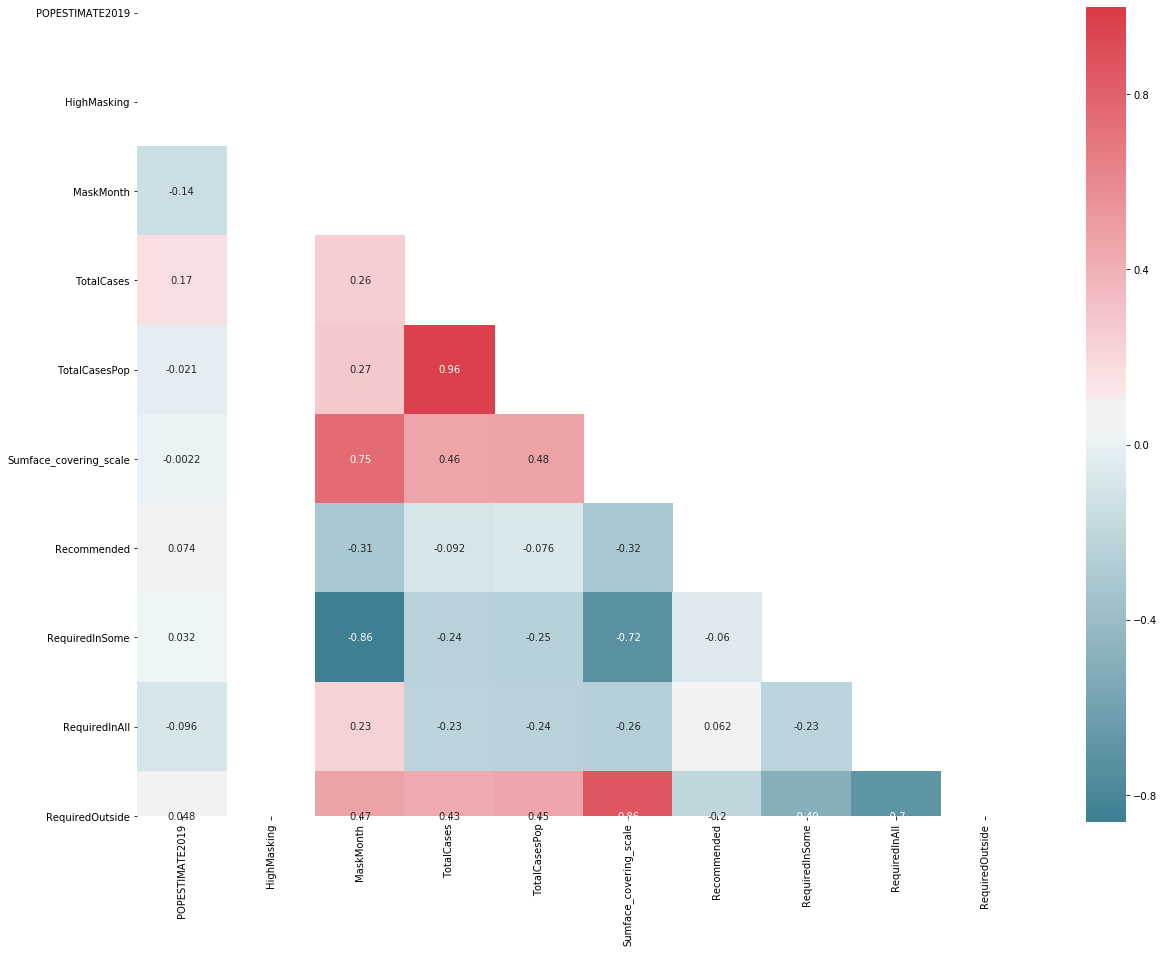

In [537]:
# view a correlation matrix heatmap
f, ax = plt.subplots(figsize=(20, 15))
corr = df_mask_required_high.corr()
matrix = np.triu(corr)
sns.heatmap(corr, mask=matrix, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

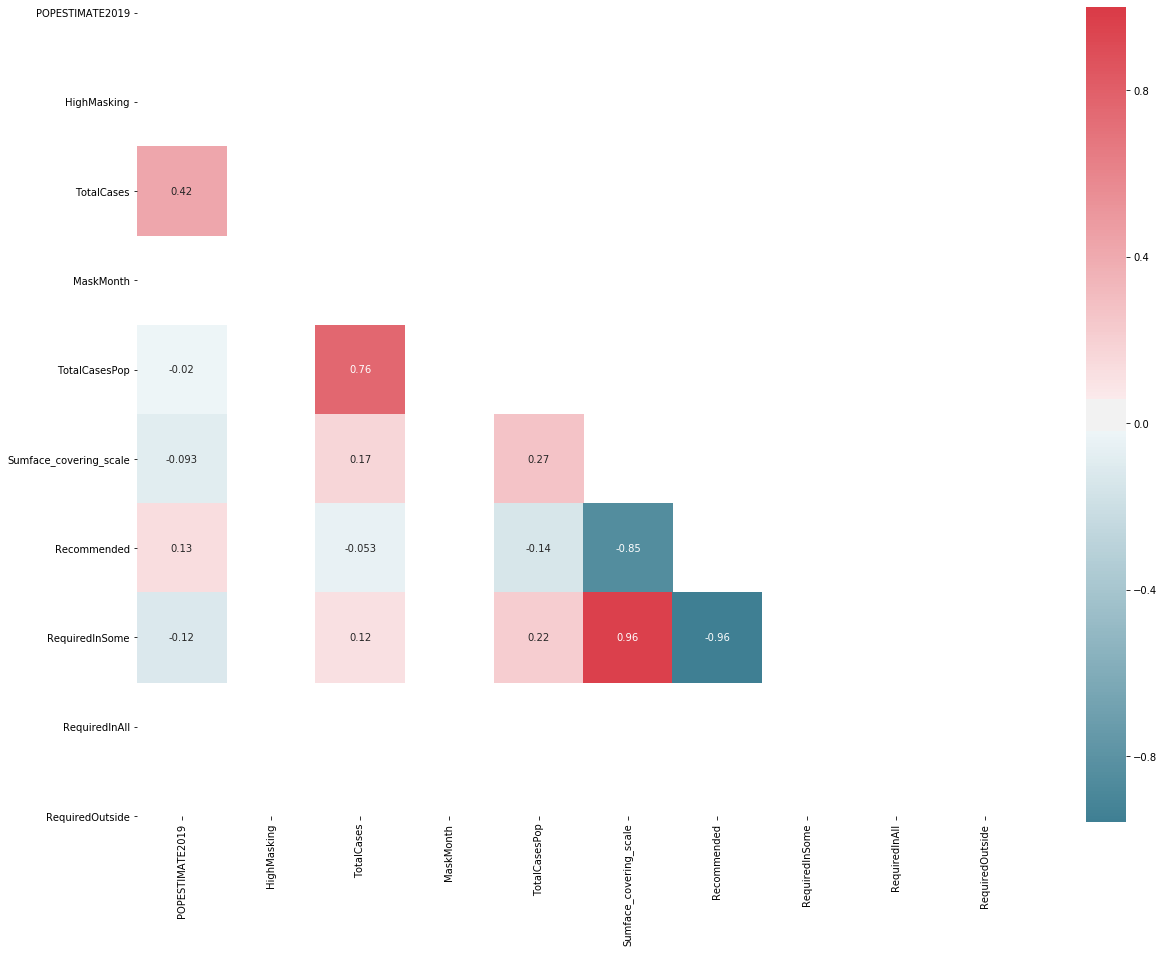

In [538]:
# view a correlation matrix heatmap
f, ax = plt.subplots(figsize=(20, 15))
corr = df_mask_required_low.corr()
matrix = np.triu(corr)
sns.heatmap(corr, mask=matrix, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

Text(0.5, 1.0, 'LOW - Masking scale 2 compared to Total Covid Cases (per 100,000)')

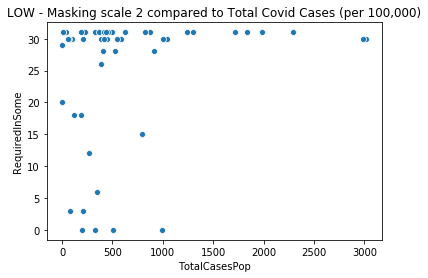

In [543]:
sns.scatterplot(data=df_mask_required_low, x="TotalCasesPop", y="RequiredInSome",
                sizes=(20, 100), hue_norm=(0, 3),
                legend='full').set_title('LOW - Masking scale 2 compared to Total Covid Cases (per 100,000)')    

Text(0.5, 1.0, 'LOW - Masking recommended compared to Total Covid Cases (per 100,000)')

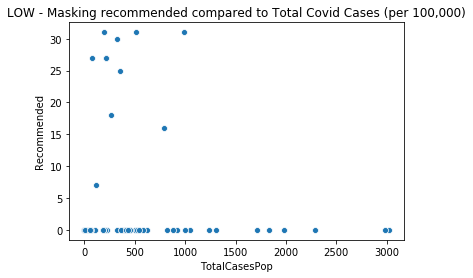

In [544]:
sns.scatterplot(data=df_mask_required_low, x="TotalCasesPop", y="Recommended",
                sizes=(20, 100), hue_norm=(0, 3),
                legend='full').set_title('LOW - Masking recommended compared to Total Covid Cases (per 100,000)')    

Text(0.5, 1.0, 'HIGH - Masking Required Outside compared to Total Covid Cases (per 100,000)')

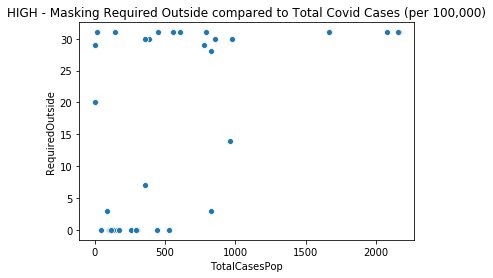

In [549]:
sns.scatterplot(data=df_mask_required_high, x="TotalCasesPop", y="RequiredOutside",
                sizes=(20, 100), hue_norm=(0, 3),
                legend='full').set_title('HIGH - Masking Required Outside compared to Total Covid Cases (per 100,000)')    

Text(0.5, 1.0, 'HIGH - Masking scale 2 compared to Total Covid Cases (per 100,000)')

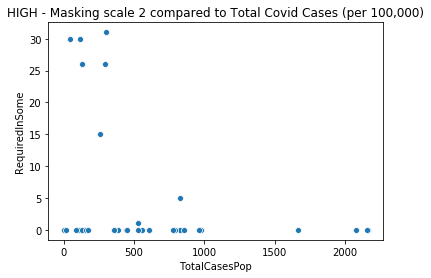

In [550]:
sns.scatterplot(data=df_mask_required_high, x="TotalCasesPop", y="RequiredInSome",
                sizes=(20, 100), hue_norm=(0, 3),
                legend='full').set_title('HIGH - Masking scale 2 compared to Total Covid Cases (per 100,000)')    

In [556]:
q = """SELECT 
            state
            ,YYYYMM
            ,RequiredInSome
            ,Sumface_covering_scale
            ,TotalCasesPop
        FROM df_mask_required_high
        where state = 'Massachusetts'
        UNION
        SELECT 
            state
            ,YYYYMM
            ,RequiredInSome
            ,Sumface_covering_scale
            ,TotalCasesPop
        FROM df_mask_required_low
        where state = 'Georgia'
        
;"""
pysqldf(q)


,state,YYYYMM,RequiredInSome,Sumface_covering_scale,TotalCasesPop
0,Georgia,202001,20,40.0,0.000000
1,Georgia,202002,29,58.0,0.000000
2,Georgia,202003,31,62.0,37.005213
3,Georgia,202004,3,33.0,210.361780
4,Georgia,202005,0,31.0,195.894993
5,Georgia,202006,0,30.0,322.375778
6,Georgia,202007,0,31.0,989.515064
7,Georgia,202008,15,46.0,792.273229
8,Georgia,202009,30,60.0,447.895878
9,Georgia,202010,31,62.0,402.771934


In [142]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.regressionplots import abline_plot

In [486]:
def multi_regression(df,x=['Sumface_covering_scale','RequiredInSome'],Y=['TotalCasesPop']):
    sns.scatterplot(
    data=df, x="TotalCasesPop", y="Sumface_covering_scale",
    sizes=(20, 100), hue_norm=(0, 3),
    legend='full').set_title('Masking compared to Total Covid Cases (per 100,000)')    
    df=df[['TotalCasesPop','Sumface_covering_scale','Recommended','RequiredInSome','RequiredInAll','RequiredOutside']]
    scaler=MinMaxScaler()
    df = scaler.fit_transform(df)
    df = pd.DataFrame(data=df, columns=['TotalCasesPop','Sumface_covering_scale','Recommended','RequiredInSome','RequiredInAll','RequiredOutside'])
    X = df[x]
    y = df[Y]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1001)

        # train the model
    model = sm.OLS(y_train, X_train.astype(float))
        # fit the data to the model
    results = model.fit()
        # make a prediction on the data
    ypred = results.predict(X_test.astype(float))
        # print the results
    print(results.summary())



LOW MASK USAGE
                            OLS Regression Results                            
Dep. Variable:          TotalCasesPop   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     1.991
Date:                Sun, 01 Aug 2021   Prob (F-statistic):              0.151
Time:                        16:07:38   Log-Likelihood:                 5.1245
No. Observations:                  39   AIC:                            -4.249
Df Residuals:                      36   BIC:                            0.7417
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Sumface_cover

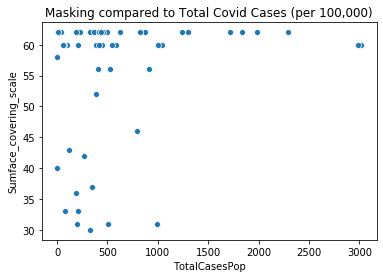

In [487]:
print('LOW MASK USAGE')
multi_regression(df_mask_required_low,x=['Sumface_covering_scale','Recommended','RequiredInSome','RequiredInAll','RequiredOutside'])

HIGH MASK USAGE
                            OLS Regression Results                            
Dep. Variable:          TotalCasesPop   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     2.037
Date:                Sun, 01 Aug 2021   Prob (F-statistic):              0.126
Time:                        16:07:42   Log-Likelihood:                 5.2323
No. Observations:                  26   AIC:                           -0.4646
Df Residuals:                      21   BIC:                             5.826
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Sumface_cove

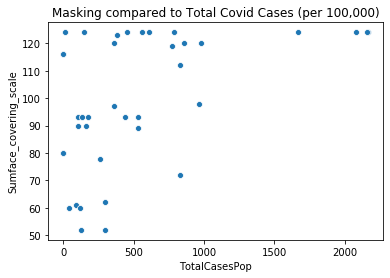

In [488]:
print('HIGH MASK USAGE')
multi_regression(df_mask_required_high,x=['Sumface_covering_scale','Recommended','RequiredInSome','RequiredInAll','RequiredOutside'])

The analysis yields a relatively low R^2 (highest .28 lowest .1), which seems to indicate that masks account for little variance in cases. All p-values are statistically insignificant ranging from 0.161 to 0.674. Examining the scatter plots seem to indicate that covid cases went up with the implementation of masking. Meaning we can't reject the null hypothesis - masked states vs unmasked states don't appear to stop the spread of covid cases at the state level. Lets look at a few states and see when they started their mask mandates compared to the covid 7 day rolling average.

### Here are bordering states, one with a mask mandate, the other without. Mask dates are shown in red.
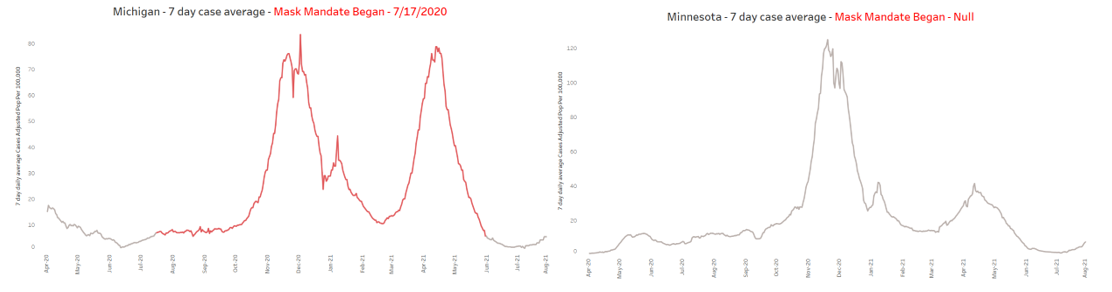


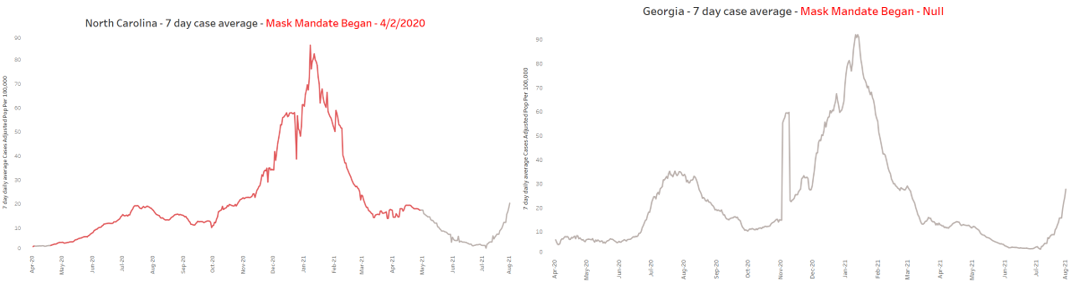

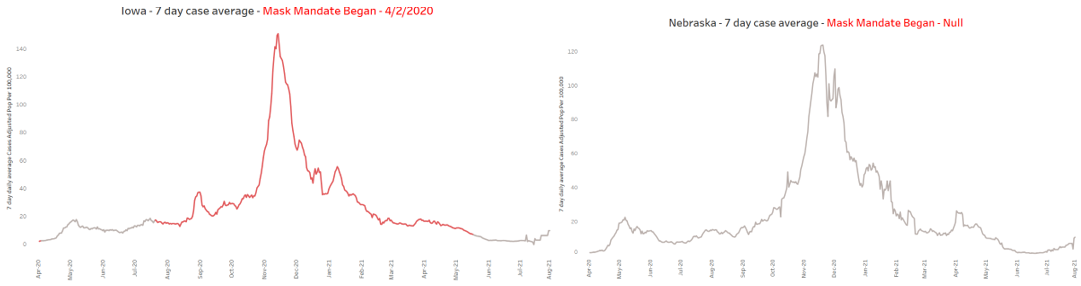

One state had a mandate, the other didn't yet they follow near identical curves. 

## Classify with SVC
Next I will see if I can classify states based on "high masking" and "low masking"based solely on cases per 100,000

In [521]:
from sklearn.model_selection import train_test_split
X = df_mask_required[['TotalCasesPop']]
y = df_mask_required[['HighMasking']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1001)

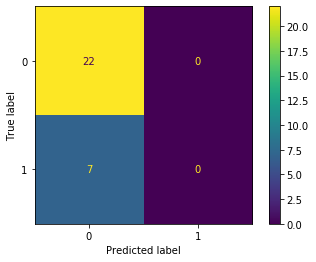

In [522]:
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
SVC(random_state=0)
plot_confusion_matrix(clf, X_test, y_test)  
plt.show() 

I was able to classify the 22 observations with low masking correct 100% of the time, while classifying high masking states incorrect 100% of the time. 

## Decision Tree
Using the same variables, I'm going to attempt to predict if the state has a mask mandate, based on cases alone in a decision tree.

In [206]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix

In [523]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [524]:
predictions = dt.predict(X_test)

In [525]:
print(classification_report(y_test,predictions))
#Return the mean accuracy on the given test data and labels.
dt.score(X_test, y_test)

              precision    recall  f1-score   support

           0       0.88      0.64      0.74        22
           1       0.38      0.71      0.50         7

    accuracy                           0.66        29
   macro avg       0.63      0.68      0.62        29
weighted avg       0.76      0.66      0.68        29



0.6551724137931034

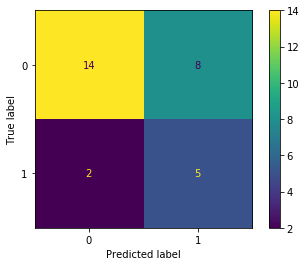

In [526]:
plot_confusion_matrix(dt, X_test, y_test)  
plt.show()

It looks like this one did a better job, with a 66% overall accuracy score, I was able to predict 71% of the "high masking" states versus 64% of the "low masking" states.  

## Random Forest
Using the same variables, I will run them through a random forest model. 

In [435]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1500)
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=1500)

              precision    recall  f1-score   support

           0       0.88      0.64      0.74        22
           1       0.38      0.71      0.50         7

    accuracy                           0.66        29
   macro avg       0.63      0.68      0.62        29
weighted avg       0.76      0.66      0.68        29



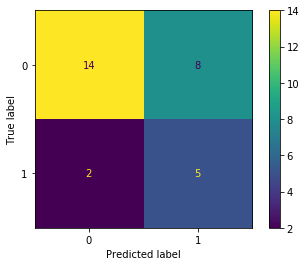

In [436]:
predictions = rfc.predict(X_test)
print(classification_report(y_test,predictions))
#Return the mean accuracy on the given test data and labels.
rfc.score(X_test, y_test)
plot_confusion_matrix(rfc, X_test, y_test)  
plt.show()

I got the same results as the decision tree.

## Final step - Entire Dataset
This final step wil repeat all the prior algorithms, but with the entire dataset. The binary indicator wil be limited to only months where there was a "face covering required"... meaning, anything above 1 (recommended). 

Also, I'm starting the dataset at April 16th, as this was the first time a state was requried to issue a mask mandate.
https://bestlifeonline.com/first-states-mandate-masks/

To account for the days with 0 cases, I'm using the 7 day rolling average. 

In [527]:
q = """

        with a as (SELECT 
            df.state
            ,date
            ,POPESTIMATE2019
            ,dailyConfirmedCases
            ,((dailyConfirmedCases)/POPESTIMATE2019)*100000 AS DailyCasesPop
            ,CASE WHEN face_covering_scale > 2 THEN 1 ELSE 0 END AS face_covering_required
        FROM df 
        inner join
            df_pop ON df_pop.STATE = df.state
        where date >20200401 and date<20210801)
    

select
    --state,,DailyCasesPop
    face_covering_required
    ,avg(DailyCasesPop) OVER (PARTITION BY state ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS DailyCasesPop7Day
from a

;"""

df_full = pysqldf(q)
df_full.tail(10)

,face_covering_required,DailyCasesPop7Day
24190,0,14.933430
24191,0,16.216965
24192,0,16.932782
24193,0,17.969483
24194,0,17.969483
24195,0,17.969483
24196,0,18.315050
24197,0,19.327068
24198,0,15.673931
24199,0,20.092252


Text(0.5, 1.0, 'Masking compared to Total Covid Cases (per 100,000)')

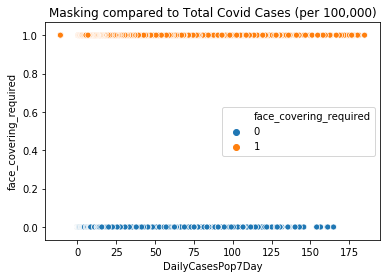

In [528]:
sns.scatterplot(
    data=df_full, x="DailyCasesPop7Day", y="face_covering_required", hue="face_covering_required",
    sizes=(20, 100), hue_norm=(0, 3),
    legend='full').set_title('Masking compared to Total Covid Cases (per 100,000)')

In [529]:
X = df_full[['DailyCasesPop7Day']]
y = df_full['face_covering_required']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1001)

0.7108815426997245


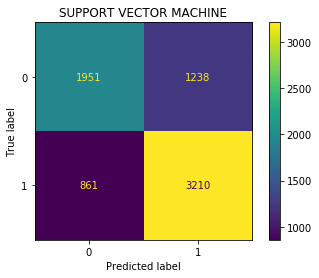

In [557]:
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
SVC(random_state=0)
print(clf.score(X_test, y_test))
plot_confusion_matrix(clf, X_test, y_test) 
plt.title("SUPPORT VECTOR MACHINE")
plt.show() 

Not bad. This was much better when comparing the entire country. 

## Decision Tree

              precision    recall  f1-score   support

           0       0.62      0.61      0.61      3189
           1       0.69      0.70      0.70      4071

    accuracy                           0.66      7260
   macro avg       0.65      0.65      0.65      7260
weighted avg       0.66      0.66      0.66      7260



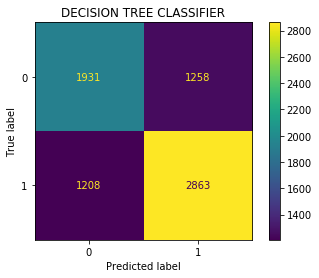

In [558]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
predictions = dt.predict(X_test)
print(classification_report(y_test,predictions))
#Return the mean accuracy on the given test data and labels.
dt.score(X_test, y_test)
plot_confusion_matrix(dt, X_test, y_test)  
plt.title("DECISION TREE CLASSIFIER")
plt.show()

## Random Forest

              precision    recall  f1-score   support

           0       0.62      0.60      0.61      3189
           1       0.69      0.70      0.70      4071

    accuracy                           0.66      7260
   macro avg       0.66      0.65      0.65      7260
weighted avg       0.66      0.66      0.66      7260



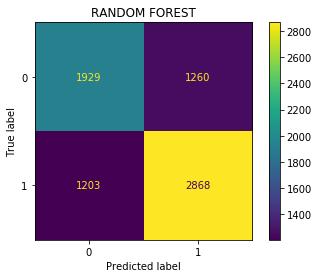

In [559]:
rfc = RandomForestClassifier(n_estimators=1500)
rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)
print(classification_report(y_test,predictions))
#Return the mean accuracy on the given test data and labels.
rfc.score(X_test, y_test)
plot_confusion_matrix(rfc, X_test, y_test)  
plt.title("RANDOM FOREST")
plt.show()